# Setup and load in the data

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Machine learning model and splitting the data
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization 
import matplotlib.pyplot as plt

In [2]:
# Load the data (replace 'file.csv' with your actual file path)
complete_df = pd.read_csv('Resources/complete_data.csv')

# Convert 'Date' column to datetime format
complete_df['Date'] = pd.to_datetime(complete_df['Date'], errors='coerce')

# Display the results
complete_df.head()

,Date,Index SA,Redfin HPI MoM,Case Shiller Index MoM,period_duration,region_type,table_id,is_seasonally_adjusted,region,state,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,30_Year_%,price_drops_is_blank,price_drops_mom_is_blank,price_drops_yoy_is_blank
0,2012-01-01,59.9,0.00%,-0.00048,30,state,23,f,Oklahoma,Oklahoma,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
1,2012-01-01,59.9,0.00%,-0.00048,30,state,10,f,New Hampshire,New Hampshire,...,0.000000,0.000000,0.0,0.007093,0.000636,-0.000240,3.915,True,True,True
2,2012-01-01,59.9,0.00%,-0.00048,30,state,42,f,Virginia,Virginia,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
3,2012-01-01,59.9,0.00%,-0.00048,30,state,47,f,Michigan,Michigan,...,0.000000,0.000000,0.0,0.013045,-0.000528,0.000734,3.915,True,True,True
4,2012-01-01,59.9,0.00%,-0.00048,30,state,12,f,New Jersey,New Jersey,...,0.000549,0.000502,0.0,0.007897,0.001832,0.006060,3.915,False,False,True


## Preprocessing

In [3]:
# Convert categorical columns using one-hot encoding
complete_df = pd.get_dummies(complete_df, columns=['region_type', 'is_seasonally_adjusted', 
                                                   'region', 'state', 'property_type'], drop_first=True)

In [4]:
# Clean and convert any Percentage Strings
complete_df['Redfin HPI MoM'] = complete_df['Redfin HPI MoM'].str.rstrip('%').astype(float) / 100

In [5]:
# Fill any missing values with the mean
complete_df = complete_df.fillna(complete_df.mean())

In [7]:
# Select numeric columns from the DataFrame
numeric_df = complete_df.select_dtypes(include=[np.number])

# Show the min and max values for all columns
for col in numeric_df.columns:
    print(f"{col}: Min = {numeric_df[col].min()}, Max = {numeric_df[col].max()}")

Index SA: Min = 59.9, Max = 172.1
Redfin HPI MoM: Min = -0.0012, Max = 0.019
Case Shiller Index MoM: Min = -0.00697, Max = 0.0189
period_duration: Min = 30, Max = 30
table_id: Min = 1, Max = 51
median_sale_price: Min = 7000, Max = 3275000
median_sale_price_mom: Min = -0.913, Max = 22.15270935960591
median_sale_price_yoy: Min = -0.9413467741935484, Max = 12.571428571428571
median_list_price: Min = 53000.0, Max = 4700000.0
median_list_price_mom: Min = -0.7438838754720863, Max = 3.5786441713492305
median_list_price_yoy: Min = -0.7250752500270485, Max = 3.630526176098192
median_ppsf: Min = 3.0, Max = 40906.0
median_ppsf_mom: Min = -0.9974014314844518, Max = 312.172894350185
median_ppsf_yoy: Min = -0.9976036845276812, Max = 243.25566423457764
median_list_ppsf: Min = 27.0, Max = 1873.0
median_list_ppsf_mom: Min = -0.9554022464607624, Max = 20.1536630306659
median_list_ppsf_yoy: Min = -0.9491803461237516, Max = 21.02027881762565
homes_sold: Min = 1, Max = 53605
homes_sold_mom: Min = -0.9, Max

In [9]:
# Set lower and upper limits for months_of_supply_mom
lower_limit = -50  
upper_limit = 40  

# Set lower and upper limits for median_dom 
lower_limit_dom = 0  
upper_limit_dom = 500  


# Apply log transformation to handle wide range of values
complete_df['median_sale_price_log'] = np.log1p(complete_df['median_sale_price'])
complete_df['median_ppsf_log'] = np.log1p(complete_df['median_ppsf'])

# Apply a cap on features w/outliers
complete_df['months_of_supply_mom'] = np.clip(complete_df['months_of_supply_mom'], lower_limit, upper_limit)
complete_df['median_dom'] = np.clip(complete_df['median_dom'], lower_limit, upper_limit)

In [10]:
# Engineer interaction features
complete_df['price_per_sqft_ratio'] = complete_df['median_sale_price'] / complete_df['median_ppsf']
complete_df['inventory_to_sales_ratio'] = complete_df['inventory'] / complete_df['homes_sold']

# Handle cases where division might result in NaN or infinite values
complete_df['price_per_sqft_ratio'] = complete_df['price_per_sqft_ratio'].fillna(0).replace(np.inf, 0)
complete_df['inventory_to_sales_ratio'] = complete_df['inventory_to_sales_ratio'].fillna(0).replace(np.inf, 0)

/tmp/ipykernel_16364/295123507.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  complete_df['price_per_sqft_ratio'] = complete_df['median_sale_price'] / complete_df['median_ppsf']
/tmp/ipykernel_16364/295123507.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  complete_df['inventory_to_sales_ratio'] = complete_df['inventory'] / complete_df['homes_sold']


## Split the data into training (1/1/2014 - 2/28/2013) and testing sets (3/1/23 - 9/30/2024) and define our target. `median_sales_price`.

In [11]:
# Split the dataset into training and testing sets based on the Date column
train_data = complete_df[(complete_df['Date'] >= '2014-01-01') & (complete_df['Date'] <= '2023-2-28')]
test_data = complete_df[(complete_df['Date'] >= '2023-03-01') & (complete_df['Date'] <= '2024-09-30')]

# Check the split
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 27407 rows
Testing data: 4760 rows


In [12]:
# Drop the Date column along with redundant columns
columns_to_drop = ['Date', 'Case Shiller Index MoM', 'period_duration', 'table_id']  

# Define the train and test data
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [13]:
# Define the target variable (y)
y_train = train_data['median_sale_price']
y_test = test_data['median_sale_price']

# Define the features (X) by dropping only the target column 
X_train = train_data.drop(columns=['median_sale_price'])
X_test = test_data.drop(columns=['median_sale_price'])

print(X_train.columns == X_test.columns)  

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


## Initialize, Train and fit our Random Forest model - Use Regressor as target variable `median_sales_price` is continuous.

In [14]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [15]:
# Fit the model on the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [16]:
# Use the model to predict on the test data
y_pred = rf_model.predict(X_test)

## Evaluate Performance

In [17]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 364243073.7831933
Mean Absolute Error: 733.7138655462185
R² Score: 0.990672467577012


In [18]:
# Calculate the top 25 features and sort in descending order
importances = rf_model.feature_importances_ 
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]  

top_25_features = feature_names[sorted_indices][:25]  
print("Top 25 Features:", top_25_features)

Top 25 Features: Index(['median_sale_price_log', 'inventory', 'median_sale_price_mom',
       'median_ppsf_log', 'median_ppsf_yoy', 'avg_sale_to_list_yoy',
       'median_list_ppsf_mom', 'homes_sold', 'price_per_sqft_ratio',
       'months_of_supply', '30_Year_%', 'median_ppsf', 'median_ppsf_mom',
       'inventory_to_sales_ratio', 'new_listings', 'region_Maine',
       'median_dom', 'median_list_price_mom', 'months_of_supply_mom',
       'median_dom_yoy', 'median_dom_mom', 'median_list_price',
       'Redfin HPI MoM', 'median_list_price_yoy', 'median_list_ppsf_yoy'],
      dtype='object')


In [21]:
# Create a DataFrame for the top 25 features and their importance scores
top_25_importance_df = pd.DataFrame({
    'Feature': top_25_features,  # Your top 25 features list
    'Importance': importances[sorted_indices][:25]  # Corresponding importance scores
})

# Sort by importance scores (descending order) for clarity
top_25_importance_df = top_25_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(top_25_importance_df)

# Save as CSV for further analysis, if needed
top_25_importance_df.to_csv('Resources/top_25_feature_importance.csv', index=False)


                     Feature  Importance
0      median_sale_price_log    0.998676
1                  inventory    0.000164
2      median_sale_price_mom    0.000121
3            median_ppsf_log    0.000101
4            median_ppsf_yoy    0.000080
5       avg_sale_to_list_yoy    0.000063
6       median_list_ppsf_mom    0.000062
7                 homes_sold    0.000058
8       price_per_sqft_ratio    0.000053
9           months_of_supply    0.000048
10                 30_Year_%    0.000044
11               median_ppsf    0.000037
12           median_ppsf_mom    0.000036
13  inventory_to_sales_ratio    0.000034
14              new_listings    0.000034
15              region_Maine    0.000033
16                median_dom    0.000030
17     median_list_price_mom    0.000030
18      months_of_supply_mom    0.000024
19            median_dom_yoy    0.000022
20            median_dom_mom    0.000021
21         median_list_price    0.000020
22            Redfin HPI MoM    0.000019
23     median_li

## Redo Test to check as model reading the target as a feature

In [22]:
# Redefine X_train and X_test
X_train = train_data.drop(columns=['median_sale_price', 'median_sale_price_log'])
X_test = test_data.drop(columns=['median_sale_price', 'median_sale_price_log'])

In [23]:
# Re-fit the model on the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [24]:
# Use the model to predict on the test data
y_pred = rf_model.predict(X_test)

In [25]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 2223960593.540126
Mean Absolute Error: 9422.78256302521
R² Score: 0.9430488428284003


In [27]:
# Check for low importance features
low_importance_features = top_25_importance_df[top_25_importance_df['Importance'] < 0.00005]  # Adjust threshold as needed
print("Low-Importance Features:")
print(low_importance_features)

Low-Importance Features:
                     Feature  Importance
9           months_of_supply    0.000048
10                 30_Year_%    0.000044
11               median_ppsf    0.000037
12           median_ppsf_mom    0.000036
13  inventory_to_sales_ratio    0.000034
14              new_listings    0.000034
15              region_Maine    0.000033
16                median_dom    0.000030
17     median_list_price_mom    0.000030
18      months_of_supply_mom    0.000024
19            median_dom_yoy    0.000022
20            median_dom_mom    0.000021
21         median_list_price    0.000020
22            Redfin HPI MoM    0.000019
23     median_list_price_yoy    0.000016
24      median_list_ppsf_yoy    0.000016


In [28]:
# Extract feature importances from the updated model
importances = rf_model.feature_importances_

# Get feature names from the updated X_train
feature_names = X_train.columns

# Sort features by importance in descending order
sorted_indices = importances.argsort()[::-1]
top_n = 25  # Number of top features to extract
top_features = feature_names[sorted_indices][:top_n]
top_importances = importances[sorted_indices][:top_n]

# Display the recalculated top features and their importance scores
for i, (feature, importance) in enumerate(zip(top_features, top_importances), start=1):
    print(f"{i}. {feature}: {importance}")


1. median_list_price: 0.5393484680133722
2. median_list_ppsf: 0.17967186137085844
3. price_per_sqft_ratio: 0.1488286782276986
4. median_ppsf: 0.05116027288141364
5. median_ppsf_log: 0.05011321039819174
6. median_sale_price_yoy: 0.006347080413604018
7. median_sale_price_mom: 0.0037610251187207926
8. Index SA: 0.0037468728704321656
9. pending_sales: 0.0011223970226868914
10. inventory: 0.0010437842502342624
11. inventory_mom: 0.0008726326997679342
12. avg_sale_to_list_yoy: 0.0007278171128807677
13. inventory_yoy: 0.0007060943028251058
14. median_ppsf_mom: 0.0006984848768950989
15. avg_sale_to_list: 0.0006814575357146944
16. homes_sold: 0.0006600733926914892
17. median_ppsf_yoy: 0.0006030379527484376
18. new_listings: 0.0005718098779728756
19. homes_sold_mom: 0.0004765802944579928
20. median_list_ppsf_yoy: 0.00045599676298572567
21. off_market_in_two_weeks_mom: 0.0004315451457384222
22. sold_above_list_yoy: 0.00042791957019133736
23. off_market_in_two_weeks_yoy: 0.0004129844565729983
24. 

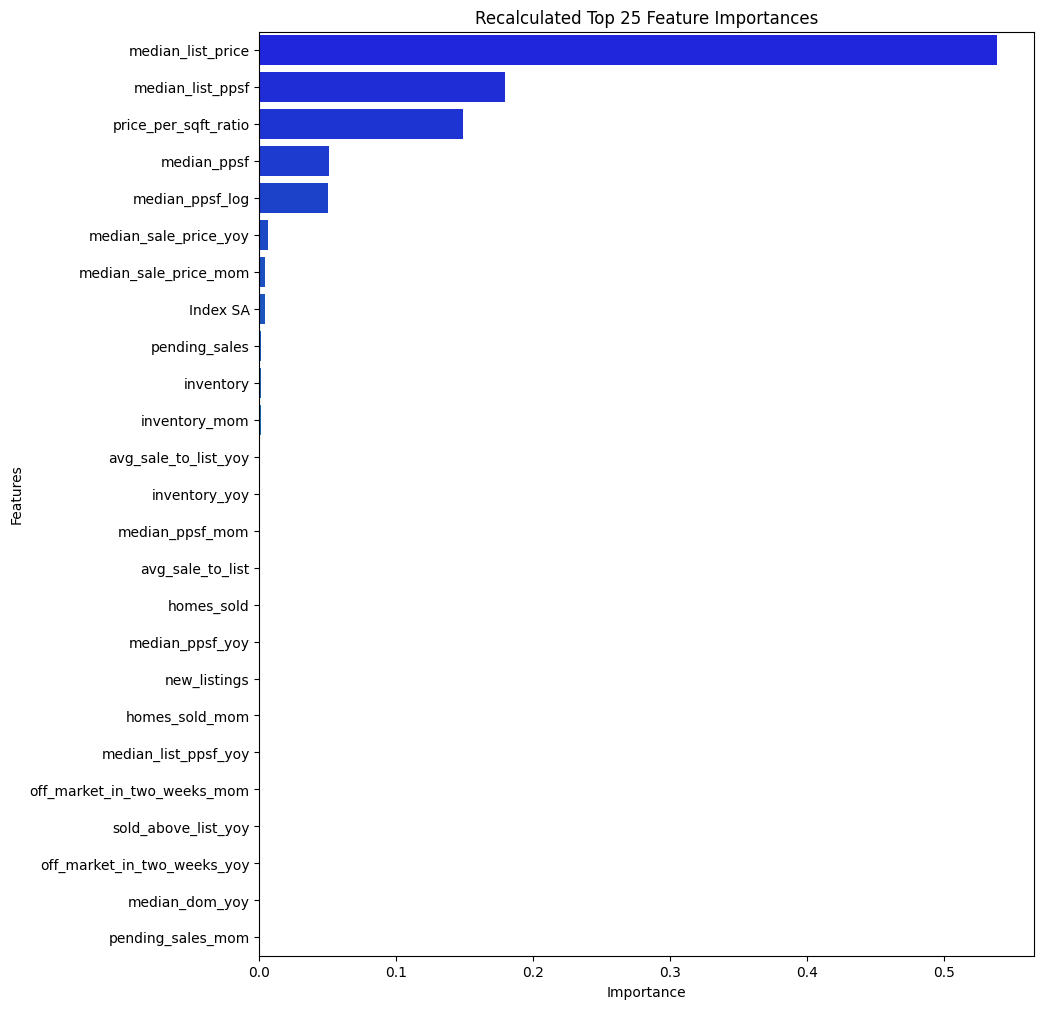

In [33]:
# Plot the top 25 features
plt.figure(figsize=(10, 12))
sns.barplot(y=top_features, x=top_importances, orient="h", palette="winter", hue=top_features, dodge=False, legend=False)
plt.title("Recalculated Top 25 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")

# Save the plot as a PNG file
plt.savefig('Resources/updated_top_25_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Apply findings from corrected model and run new model using Top 25 features.

In [ ]:
# Multiply interactions that have higher influence in feature set 
X_train['ppsf_inventory_interaction'] = X_train['median_ppsf_log'] * X_train['inventory']
X_test['ppsf_inventory_interaction'] = X_test['median_ppsf_log'] * X_test['inventory']


In [ ]:
# Check for non-linear relatioins by squaring the ppsq ratio
X_train['price_per_sqft_ratio_squared'] = X_train['price_per_sqft_ratio'] ** 2
X_test['price_per_sqft_ratio_squared'] = X_test['price_per_sqft_ratio'] ** 2


In [35]:
# Updated X_train and X_test setup
X_train_top25 = X_train[top_features] 
X_test_top25 = X_test[top_features]

In [36]:
# Re-train the model on the updated features set
rf_model.fit(X_train_top25, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [37]:
# Updated predictions using the top 25
y_pred_top25 = rf_model.predict(X_test_top25)

In [38]:
# perform updated test results report
# Calculate performance metrics
mse_top25 = mean_squared_error(y_test, y_pred_top25)
mae_top25 = mean_absolute_error(y_test, y_pred_top25)
r2_top25 = r2_score(y_test, y_pred_top25)

# Print the results
print(f"Mean Squared Error: {mse_top25}")
print(f"Mean Absolute Error: {mae_top25}")
print(f"R² Score: {r2_top25}")

Mean Squared Error: 2056267022.8258402
Mean Absolute Error: 8629.376680672269
R² Score: 0.9473431378488051


## Utilize above setup with Top 25 features and add in additional feature engineering

In [39]:
# Combine relevant features to create new ratio metrics (have to add in the + 1e-10 to avoid dividing by 0
X_train['inventory_to_sales_ratio'] = X_train['inventory'] / (X_train['homes_sold'] + 1e-10)  
X_test['inventory_to_sales_ratio'] = X_test['inventory'] / (X_test['homes_sold'] + 1e-10)

In [42]:
# Compute all new features at once to avoid fragmentation warnings and builds in the above cell as in the train, test sets
new_features_train = pd.DataFrame({
    'ppsf_inventory_interaction': X_train['median_ppsf_log'] * X_train['inventory'],
    'price_per_sqft_ratio_squared': X_train['price_per_sqft_ratio'] ** 2
})

new_features_test = pd.DataFrame({
    'ppsf_inventory_interaction': X_test['median_ppsf_log'] * X_test['inventory'],
    'price_per_sqft_ratio_squared': X_test['price_per_sqft_ratio'] ** 2
})

# Concatenate these new features with the original DataFrame
X_train = pd.concat([X_train, new_features_train], axis=1)
X_test = pd.concat([X_test, new_features_test], axis=1)

In [43]:
# Updated X_train and X_test setup
X_train_top25 = X_train[top_features] 
X_test_top25 = X_test[top_features]

In [44]:
# Re-train the model on the updated features set
rf_model.fit(X_train_top25, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [45]:
# Updated predictions using the top 25
y_pred_top25 = rf_model.predict(X_test_top25)

In [46]:
# perform updated test results report
# Calculate performance metrics
mse_top25 = mean_squared_error(y_test, y_pred_top25)
mae_top25 = mean_absolute_error(y_test, y_pred_top25)
r2_top25 = r2_score(y_test, y_pred_top25)

# Print the results
print(f"Mean Squared Error: {mse_top25}")
print(f"Mean Absolute Error: {mae_top25}")
print(f"R² Score: {r2_top25}")

Mean Squared Error: 2056267022.8258402
Mean Absolute Error: 8629.376680672269
R² Score: 0.9473431378488051


In [47]:
# Calculate the difference and round to 2 decimal places to mirror actual dollar figure format

# Set up the rounding to 2 decimal places
actual_values = np.round(y_test.values, 2)  
predicted_values = np.round(y_pred_top25, 2)  
differences = np.round(actual_values - predicted_values, 2)  

# Create the results DataFrame
results = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values,
    'Difference': differences
})

# Save the results to a CSV file
results.to_csv('Resources/random_forest_optimized_results.csv', index=False)

# Confirm the saved file contains properly rounded values
print("Results saved with Actual, Predicted and Difference columns!")

Results saved with Actual, Predicted and Difference columns!


# Findings: 
**Consistency: The model is stable, and the additional features didn’t introduce added complexity or noise.**

**Efficiency: We have managed to maintain strong predictive power while working with a reduced, streamlined feature set.**

**Validation: This outcome reinforces the earlier approach and it is operating at max optimization.**